# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Is there a potential for microbial growth in the product?' , based on the Input Data

In [101]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

## File name and other important parameters like ngram_range set

In [102]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
#n_components = 0

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) - Q1

In [103]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [104]:
fsha_data = pd.read_excel(filename)

In [105]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites,Table1_Row1_Moulluscs,Table1_Row2_Moulluscs,Table1_Row3_Moulluscs,Table1_Row4_Moulluscs,Table1_Row5_Moulluscs,Table1_Row6_Moulluscs
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,#53697 FSHA HT Baguette 4 Cheese UA 2.07.19.xlsm,HT Baguette Four Cheese Flavor,53697,Hrusteam Baguette,Refresh,Launch new seasoning 4 Cheese NL-502-352-9 on ...,NaN,Anna Nikonova,ESSA,Moscow,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,#57686 FSHA 5.4.1 Red Caviar Azov.xlsm,Lay's Caviar IO 2019 RUS Asov,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,#57686 FSHA 5.4.1 Red Caviar Kashira.xlsm,Lay's Caviar IO 2019 RUS Kashira,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,53354-FSHA-In Process 13.12.18.xlsm,Soft and Mild Iberia 2019,53354,Cheetos Palomito,Re Launch,"Re Launch of Cheetos Palomitos, Soft Extruded ...",CP2019,David Labrado 07770646572,ESSA,Beaumont Park,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
fsha_data.columns

Index(['File Name', 'projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       ...
       'Table1_Row6_Molluscs', 'Table1_Row6_Mustard',
       'Table1_Row6_Sesame Seeds', 'Table1_Row6_Sulphites',
       'Table1_Row1_Moulluscs', 'Table1_Row2_Moulluscs',
       'Table1_Row3_Moulluscs', 'Table1_Row4_Moulluscs',
       'Table1_Row5_Moulluscs', 'Table1_Row6_Moulluscs'],
      dtype='object', length=136)

In [58]:
#Check few categorical values
fsha_data[['cookedOrHeated', 'specificStorage']][:5]

,cookedOrHeated,specificStorage
0,No,No
1,No,"Keep at temperature 25 °C, <75% humidity"
2,no,store the product for no more than 24 hours at...
3,no,store the product for no more than 24 hours at...
4,NO,Ensure the bag is closed and consumed after 2 ...


In [111]:
fsha_data.columns[:35].values

array(['File Name', 'projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       'Current TSG Stage', 'FSAssessors', 'FSDate', 'WHTD',
       'manufacSite', 'PlantTrial', 'packMaterial', 'CPD-ProdName',
       'CPD-ProdName-Desc', 'procPlat', 'intrinsicProd', 'preservatives',
       'pH', 'waterActivity', 'packaging', 'otherFSA', 'allergens',
       'prodStorageDist', 'shelfLife', 'TCG', 'foodSafetyProdClaims',
       'cookedOrHeated', 'specificStorage', 'labelingInstructions',
       'mishandled'], dtype=object)

# Based on Analysis select the Features (X)

In [113]:
#selecting set of columns as Features
features_df=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','allergensLabeledIMAF']]


# Standardize Categorical Columns (those columns which have values in a fixed set, ex: packaging) 

In [61]:
#ph value label
features_df['PH_label']=features_df['pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
features_df['PH_label']=features_df['PH_label'].apply(lambda x:ph_process(x))    

"""
#'specificStorage'column label
print("specificStorage from extract")
def specificStorage(x):
    x=str(x.lower())
    print(x)
    if x.__contains__('do not store'):
        return 'do not store open product'
    elif x.__contains__('ambient')  :
        return 'ambient storage'
    elif x.__contains__('no')  :
        return 'no'
    else:
        return 'NA'
features_df['specificStorage_label']=features_df['specificStorage'].apply(lambda x:specificStorage(x))   
print("specificStorage after transformation")
print(features_df['specificStorage_label'])

#'cookedorHeated'column label
def cookedOrHeated(x):
    x=str(x.lower())
    #print(x)
    if x.__contains__('no'):
        return 'no'
    elif x.__contains__('ready to eat')  :
        return 'no'
    else:
        return 'NA'
features_df['cookedOrHeated_label']=features_df['cookedOrHeated'].apply(lambda x:cookedOrHeated(x))    
#print(features_df['cookedOrHeated_label'])
"""
#'prod_storageDist'column label
print("prod_storageDist from extract")
def prod_storageDist(x):
    
    x=str(x)
    x=x.lower()
   # print(x)
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
features_df['prod_storageDist_label']=features_df['prodStorageDist'].apply(lambda x:prod_storageDist(x))      
print("prod_storageDist after transformation")
print(features_df['prod_storageDist_label'][:5])

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
features_df['waterActivity_label']=features_df['waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
print("packaging from extract")
def packaging(x):
    x=str(x)
    x=x.lower()
    #print(x)
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
    
features_df['packaging_label']=features_df['packaging'].apply(lambda x: packaging(x))  
print("packaging after data transformation")
print(features_df['packaging_label'][:5])
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
features_df['preservatives_label']=features_df['preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
features_df['otherFSA_label']=features_df['otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a',x)):
        return 'NA'
    else:
        return(x)

features_df['foodSafety_prodClaims_label']=features_df['foodSafetyProdClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
features_df['targetMarket_label']=features_df['targetMarket'].apply(lambda x:targetMarket(x))



prod_storageDist from extract
prod_storageDist after transformation
0    Keep away from sun
1                    NA
2                    NA
3                    NA
4    Keep away from sun
Name: prod_storageDist_label, dtype: object
packaging from extract
packaging after data transformation
0                 atmosphere
1                        n/a
2                   standard
3                   standard
4    window with clear film.
Name: packaging_label, dtype: object


# Drop the raw columns and retain transformed columns

In [62]:
features_df=features_df.drop(['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA','prodStorageDist','foodSafetyProdClaims','targetMarket'],axis=1)


In [63]:
def conv_str(x):
    
    x=str(x)
    x=x.lower()
    return (x)
 
features_df['allergens']=features_df['allergens'].apply(lambda x:conv_str(x))  
features_df['newIngredient']=features_df['newIngredient'].apply(lambda x:conv_str(x))  
features_df['allergensLabeledIMAF']=features_df['allergensLabeledIMAF'].apply(lambda x:conv_str(x)) 

In [64]:
train_df = features_df

In [65]:
train_df.head()

,allergens,newIngredient,allergensLabeledIMAF,PH_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,allergens in seasonings:\ncq69 vegetable blend...,yes,"milk, lactose : milk, lactose",0,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
1,no new allergen to the line from seasonings. 4...,yes,"milk, lactose, sulphites 1ppm, gluten < 3ppm.",0,NA,low,n/a,NA,NA,NA,no
2,"inherent: milk, lactose, wheat, gluten, fish c...",no,"milk, lactose, wheat and gluten < 3ppm, sulphi...",0,NA,low,standard,NA,NA,NA,Allergy
3,"inherent : inherent: milk, lactose, wheat, gl...",no,"milk, lactose, wheat and gluten < 3ppm, sulphi...",0,NA,low,standard,NA,NA,NA,Allergy
4,milk from seasoning.,no,na : na : milk,0,Keep away from sun,low,window with clear film.,NA,NA,gluten free?,kids from 4-10


In [66]:
train_df.PH_label.value_counts()

0    202
3      7
Name: PH_label, dtype: int64

# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [67]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)

    x_train = x_train.astype('float32')
    return x_train

In [68]:
norm_allergens = normalize_corpus(train_df['allergens'])
norm_preservatives = normalize_corpus(train_df['preservatives_label'])
norm_pH = normalize_corpus(train_df['PH_label'])
norm_waterActivity = normalize_corpus(train_df['waterActivity_label'])
norm_packaging = normalize_corpus(train_df['packaging_label'])
norm_otherFSA = normalize_corpus(train_df['otherFSA_label'])
norm_prodStorageDist = normalize_corpus(train_df['prod_storageDist_label'])
norm_foodSafetyProdClaims = normalize_corpus(train_df['foodSafety_prodClaims_label'])
norm_targetMarket = normalize_corpus(train_df['targetMarket_label'])
norm_newIngredient = normalize_corpus(train_df['newIngredient'])

# Define method to perform Text standardization (categorical data, text data). This method peforms a number of steps. It standardizes and vectorizes Text features, performs  Dimensionality Reduction (PCA), and finally concatenates the columns to create the Feature Matrix (X) 

In [74]:
whiten = False
random_state = 42
svd_solver="full"
def preprocess_text(train_df,y,n_comp,n_gram_range):

    train_df['newIngredient'] = train_df['newIngredient'].astype('category').cat.codes
    train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
    train_df['norm_preservatives'] = normalize_corpus(train_df['preservatives_label'])
    train_df['norm_waterActivity'] = normalize_corpus(train_df['waterActivity_label'])
    train_df['norm_packaging'] = normalize_corpus(train_df['packaging_label'])
    train_df['norm_otherFSA'] = normalize_corpus(train_df['otherFSA_label'])
    train_df['norm_prodStorageDist'] = normalize_corpus(train_df['prod_storageDist_label'])
    train_df['norm_foodSafetyProdClaims'] = normalize_corpus(train_df['foodSafety_prodClaims_label'])
    train_df['norm_targetMarket'] = normalize_corpus(train_df['targetMarket_label'])
    train_df = train_df.drop(['allergens','preservatives_label','PH_label','waterActivity_label',
                              'packaging_label','otherFSA_label','prod_storageDist_label',
                               'foodSafety_prodClaims_label','targetMarket_label'],axis = 1)

    train_labels = y
    
    #Vectorize the text data for each column
    x_ngram_allergens = ngram_vectorize(train_df['norm_allergens'], train_labels,n_gram_range).toarray()
    x_ngram_preservatives = ngram_vectorize(train_df['norm_preservatives'], train_labels,n_gram_range).toarray()
    x_ngram_waterActivity = ngram_vectorize(train_df['norm_waterActivity'], train_labels,n_gram_range).toarray()
    x_ngram_packaging = ngram_vectorize(train_df['norm_packaging'],train_labels,n_gram_range).toarray()
    x_ngram_otherFSA = ngram_vectorize(train_df['norm_otherFSA'],train_labels,n_gram_range).toarray()
    x_ngram_prodStorageDist = ngram_vectorize(train_df['norm_prodStorageDist'],train_labels,n_gram_range).toarray()
    x_ngram_foodSafetyProdClaims = ngram_vectorize(train_df['norm_foodSafetyProdClaims'],train_labels,n_gram_range).toarray()
    x_ngram_targetMarket = ngram_vectorize(train_df['norm_targetMarket'],train_labels,n_gram_range).toarray()
       
    #Apply PCA on each column
    pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
    x_pca_allergens = pca.fit_transform(x_ngram_allergens)
    
    x_pca_preservatives = pca.fit_transform(x_ngram_preservatives)
    x_pca_waterActivity = pca.fit_transform(x_ngram_waterActivity)
    x_pca_packaging = pca.fit_transform(x_ngram_packaging)
    x_pca_otherFSA = pca.fit_transform(x_ngram_otherFSA)
    x_pca_prodStorageDist = pca.fit_transform(x_ngram_prodStorageDist)
    x_pca_foodSafetyProdClaims = pca.fit_transform(x_ngram_foodSafetyProdClaims)
    x_pca_targetMarket = pca.fit_transform(x_ngram_targetMarket)
    x_newIngredient=train_df['newIngredient'].values
    
    x_train = np.concatenate((x_pca_allergens,x_pca_preservatives,x_pca_waterActivity,x_pca_packaging,x_pca_otherFSA,x_pca_prodStorageDist,x_pca_foodSafetyProdClaims,x_pca_targetMarket),axis =1)
    
    print(x_train.shape)
    return x_train

# Transform Target (potentialMicrobial) into binary value (1=Yes, 0=No)

In [71]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [72]:
train_df["tags"] = impute_target(fsha_data,"potentialMicrobial")

In [73]:
y = train_df["tags"]
y.value_counts()

0    205
1      4
Name: tags, dtype: int64

# Pre-process the data (Vectorize the features using the functions defined)

In [75]:
n_components=2
ngram_range_inp=(1,2)
x_train = preprocess_text(train_df,y,n_components,ngram_range_inp)
x_train.shape

(209, 16)


(209, 16)

# Check a row of X matrix (corresponding to one FSHA Form), how it looks after vectorization

In [76]:
x_train[0]

array([-9.72680748e-02, -1.35703497e-02, -6.50971681e-02, -4.53446154e-03,
       -1.28027618e-01, -3.91945662e-03,  6.83378041e-01,  7.52314106e-02,
       -1.35331033e-02,  1.15504086e-07,  7.87282050e-01,  7.75708199e-01,
       -4.40530449e-01, -1.78784415e-01, -2.48379186e-01, -2.24912643e-01],
      dtype=float32)

# Check target - y (potentialMicrobial) distribution after binarization

In [77]:
y.value_counts()

0    205
1      4
Name: tags, dtype: int64

# This shows the data is highly imbalanced, there are 3 counts of Yes(1), and rest are No(1)

In [78]:
x_train=pd.DataFrame(x_train)

In [79]:
y = pd.DataFrame(y)

In [80]:
y.rename(columns={0:'target'}, inplace=True)

In [81]:
X, y = x_train,y

# Check the final X matrix (Vectorized form of the Text Inputs) 

In [82]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.097268,-0.013570,-0.065097,-0.004534,-0.128028,-0.003919,0.683378,0.075231,-0.013533,1.155041e-07,0.787282,0.775708,-0.440530,-0.178784,-0.248379,-0.224913
1,-0.182251,-0.054384,-0.065097,-0.004534,-0.128038,-0.003921,-0.368444,-0.421074,-0.013533,-2.034859e-08,0.883008,-0.635261,-0.549706,0.776129,-0.164104,-0.084490
2,-0.132213,-0.003500,-0.065097,-0.004535,-0.128036,-0.003921,-0.210076,-0.099517,-0.013533,-2.034860e-08,0.883008,-0.635262,-0.549712,0.776119,-0.248380,-0.224912
3,-0.143493,0.015549,-0.065097,-0.004535,-0.128041,-0.003921,-0.210075,-0.099516,-0.013533,-2.034860e-08,0.883008,-0.635262,-0.549703,0.776138,-0.248380,-0.224913
4,-0.129592,-0.091374,-0.065097,-0.004535,-0.128034,-0.003922,-0.284982,-0.318154,-0.013533,-2.034860e-08,0.787283,0.775708,-0.250995,0.007928,-0.164101,-0.084486


# Split the X and y into Train and Test data with a ratio of 0.2 (ie Test Data = 0.2 of Full data set)

In [83]:
selector = SelectKBest(f_classif, k='all')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(167, 16)
(42, 16)


# Upsample the potentialMicrobial data, since the data is highly imbalanced

In [84]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,tags
190,-0.337541,-0.517563,-0.065097,-0.004535,-0.128038,-0.003921,0.683377,0.075231,-0.013533,-2.034860e-08,-0.386790,-0.012677,0.621616,-0.005091,-0.164101,-0.084486,0
73,0.780240,0.013213,-0.065097,-0.004535,-0.128038,-0.003921,-0.398059,-0.604142,-0.013533,-2.034860e-08,-0.386790,-0.012677,-0.603883,-0.617703,0.788703,0.069769,0
68,0.780240,0.013213,-0.065097,-0.004535,-0.128038,-0.003921,-0.398059,-0.604142,-0.013533,-2.034860e-08,-0.386790,-0.012677,-0.603883,-0.617703,0.788703,0.069769,0
89,0.780240,0.013213,-0.065097,-0.004535,-0.128038,-0.003921,-0.398059,-0.604142,-0.013533,-2.034860e-08,-0.386790,-0.012677,-0.603883,-0.617703,0.788703,0.069769,0
163,-0.161871,-0.114718,-0.065097,-0.004535,-0.128038,-0.003921,0.683377,0.075231,-0.013533,-2.034860e-08,0.787283,0.775708,0.621616,-0.005091,-0.410590,0.807420,0


In [85]:
# separate minority and majority classes
not_potMicrobial = X[X.tags==0]
potMicrobial = X[X.tags==1]

In [86]:
len(not_potMicrobial)

164

In [87]:
len(potMicrobial)

3

In [88]:
# upsample minority
potMicrobial_upsampled = resample(potMicrobial,
                          replace=True, # sample with replacement
                          n_samples=len(not_potMicrobial), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_potMicrobial, potMicrobial_upsampled])

# After upsampling the target counts are same, and data is balanced

In [89]:
upsampled.tags.value_counts()

1    164
0    164
Name: tags, dtype: int64

In [90]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [91]:
y_train=y_train.reshape(y_train.shape[0],1)

In [92]:
X_train.shape

(328, 16)

In [93]:
y_train.shape

(328, 1)

# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [94]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred, average='weighted')
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train, average='weighted')
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [95]:
# Not using MultinomialNaiveBayes, because sampled data has negative components. NaiveBayes expects frequencies in the positive

results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
328
model name:Pipeline
train time: 0.000s
f1_score:   0.914
f1_score_train:   0.942
classification report:
             precision    recall  f1-score   support

          0       0.97      0.90      0.94        41
          1       0.00      0.00      0.00         1

avg / total       0.95      0.88      0.91        42

confusion matrix:
[[37  4]
 [ 1  0]]
Ridge Classifier
________________________________________________________________________________
Training: 
328
model name:RidgeClassifier
train time: 0.000s
f1_score:   0.914
f1_score_train:   0.942
classification report:
             precision    recall  f1-score   support

          0       0.97      0.90      0.94        41
          1       0.00      0.00      0.00         1

avg / total       0.95      0.88      0.91        42

confusion matrix:
[[37  4]
 [ 1  0]]
dimensionality: 16
density: 1.000000
___________________________________

# Define Neural Network model

In [96]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [97]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [98]:
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
328
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001A98901DEF0>
Train on 328 samples, validate on 42 samples
Epoch 1/100
328/328 - 0s - loss: 0.6464 - acc: 0.6707 - val_loss: 0.6436 - val_acc: 0.6905
Epoch 2/100
328/328 - 0s - loss: 0.6420 - acc: 0.6982 - val_loss: 0.6400 - val_acc: 0.6429
Epoch 3/100
328/328 - 0s - loss: 0.6196 - acc: 0.7652 - val_loss: 0.6350 - val_acc: 0.6429
Epoch 4/100
328/328 - 0s - loss: 0.6100 - acc: 0.8018 - val_loss: 0.6312 - val_acc: 0.6190
Epoch 5/100
328/328 - 0s - loss: 0.5878 - acc: 0.7988 - val_loss: 0.6265 - val_acc: 0.6190
Epoch 6/100
328/328 - 0s - loss: 0.5766 - acc: 0.8140 - val_loss: 0.6222 - val_acc: 0.6905
Epoch 7/100
328/328 - 0s - loss: 0.5607 - acc: 0.8354 - val_loss: 0.6177 - val_acc: 0.6905
Epoch 8/100
328/328 - 0s - loss: 0.5587 - acc: 0.8232 - val_loss: 0.6130 - val_acc: 0.6905
Epoch 9/1

Epoch 87/100
328/328 - 0s - loss: 0.2210 - acc: 0.9421 - val_loss: 0.3430 - val_acc: 0.8333
Epoch 88/100
328/328 - 0s - loss: 0.2394 - acc: 0.9146 - val_loss: 0.3419 - val_acc: 0.8333
Epoch 89/100
328/328 - 0s - loss: 0.2161 - acc: 0.9421 - val_loss: 0.3424 - val_acc: 0.8333
Epoch 90/100
328/328 - 0s - loss: 0.2214 - acc: 0.9238 - val_loss: 0.3410 - val_acc: 0.8333
Epoch 91/100
328/328 - 0s - loss: 0.2139 - acc: 0.9482 - val_loss: 0.3404 - val_acc: 0.8333
Epoch 92/100
328/328 - 0s - loss: 0.2212 - acc: 0.9177 - val_loss: 0.3389 - val_acc: 0.8333
Epoch 93/100
328/328 - 0s - loss: 0.2070 - acc: 0.9329 - val_loss: 0.3383 - val_acc: 0.8333
Epoch 94/100
328/328 - 0s - loss: 0.2133 - acc: 0.9299 - val_loss: 0.3381 - val_acc: 0.8333
Epoch 95/100
328/328 - 0s - loss: 0.2205 - acc: 0.9207 - val_loss: 0.3357 - val_acc: 0.8333
Epoch 96/100
328/328 - 0s - loss: 0.2148 - acc: 0.9299 - val_loss: 0.3350 - val_acc: 0.8333
Epoch 97/100
328/328 - 0s - loss: 0.2164 - acc: 0.9116 - val_loss: 0.3360 - val_

# Visualize the results from multiple Machine Learning Models (accuracy - train, accuracy - test, training time)

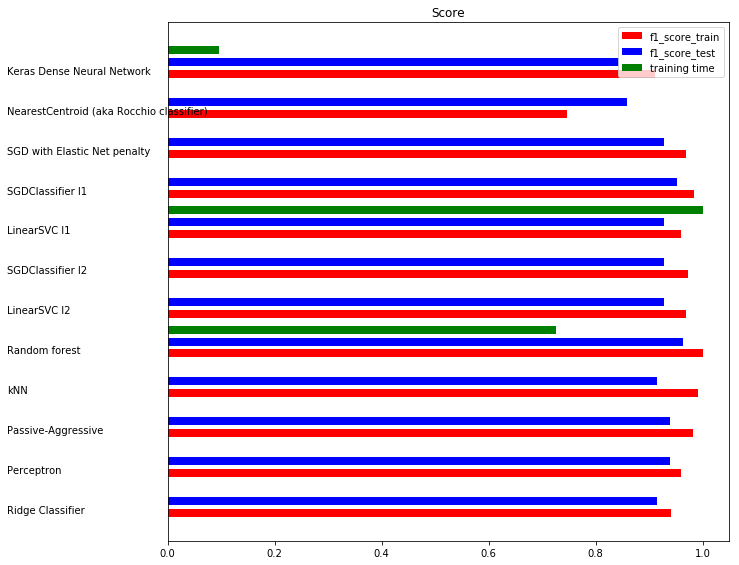

In [99]:
# make some plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results

training_time = np.array(training_time) / np.max(training_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

# Print the best model and accuracy 

In [100]:

index=np.argmax(f1_score_test)
f1score = f1_score_test[index]
print(f1score)
print(model_name[index])

0.9644291451520366
Random forest


# Result is F1-score of "Yes" is 96.4%, but the No instances are not predicted at all, as can be seen in the classification report